# Using Mitiq with Qiskit quantum programs

This notebook shows how to use Mitiq to mitigate errors in Qiskit quantum programs.

The main sections are:
* **Section 1: Computing quantum expectation values without error mitigation**
* **Section 2: Applying zero-noise extrapolation (ZNE)**
* **Section 3: Applying probabilistic error cancellation (PEC)**

Useful links:
* Qiskit repository: https://github.com/Qiskit/qiskit
* Qiskit documentation: https://qiskit.org/documentation/
* IBMQ portal: https://www.ibm.com/quantum-computing/


* Mitiq repository: https://github.com/unitaryfund/mitiq
* Mitiq documentation: https://mitiq.readthedocs.io/en/stable/
* Mitiq white paper: https://mitiq.readthedocs.io/en/stable/
* Unitary Fund:  https://unitary.fund

This notebook requires the Python packages: `qiskit` and `mitiq`. If necessary, uncomment the next code cell to install them.

In [1]:
!pip install qiskit --quiet
!pip install mitiq --quiet

In [2]:
import warnings

warnings.filterwarnings(action='ignore') # Optional warning filter

## Section 1: Computing quantum expectation values without error mitigation

### Define the circuit of interest

We first define an arbitrary circuit of interest. For simplicity, in this example we use
a two-qubit randomized-benchmarking circuit whose ideal execution is equivalent to the
identity operation.

In [5]:
import qiskit
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from mitiq.interface import convert_to_mitiq, convert_from_mitiq

n_qubits = 2
depth = 20

qiskit_circuit = rb.randomized_benchmarking_seq(
    length_vector=[depth], rb_pattern=[range(n_qubits)], group_gates="0", rand_seed=1,
)[0][0][0]

# Remove Barriers
qiskit_circuit=RemoveBarriers()(qiskit_circuit)
# Remove Measurements
qiskit_circuit=RemoveFinalMeasurements()(qiskit_circuit)
# Double conversion trick to rename qubit register
circuit = convert_from_mitiq(convert_to_mitiq(qiskit_circuit)[0], "qiskit")

print(f"Randomized benchmarking circuit with {len(circuit)} gates generated.")
# print(circuit)

Randomized benchmarking circuit with 211 gates generated.


### Execute the circuit with an noiseless backend

In [6]:
# Set the number of shots 
shots = 10 ** 5

# Initialize ideal backend (classical noiseless simulator)
ideal_backend = qiskit.Aer.get_backend('aer_simulator')

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get count
job = ideal_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Expectation value of A=|00><00|
ideal_value = counts["00"] / shots
ideal_value

1.0

### Execute the circuit with an noisy backend (without error mitigation)

In [7]:
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

# Set the number of shots 
shots = 10 ** 5

# Select a noisy backend
# noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

# Append measurements
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

# Run and get counts
print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
job = noisy_backend.run(circuit_to_run, shots=shots)
counts = job.result().get_counts()

# Compute expectation value of the observable A=|0><0|
noisy_value = counts["00"] / shots
noisy_value

Executing circuit with 211 gates using 100000 shots.


0.75779

## Section 2: Applying zero-noise extrapolation (ZNE)

### Define an executor function

We rewrite the last code cell of the previous section as a function that we call `executor`.
This function takes as input a Qiskit circuit and returns the final noisy expectation value.

Hint: It is usually better, but not necessary, to set `optimization_level=0` to avoid automatic circuit optimizations.

In [13]:
def executor(circuit, shots=10 ** 5):
    """Executes the input circuit and returns the noisy expectation value <A>, where A=|00>00|.
    """
    # Select a noisy backend
    # noisy_backend = qiskit.IBMQ.load_account().get_backend("ibmq_lima")
    noisy_backend = FakeLima() # Simulator with noise model similar to "ibmq_lima"

    # Append measurements
    circuit_to_run = circuit.copy()
    circuit_to_run.measure_all()

    # Run and get counts
    print(f"Executing circuit with {len(circuit)} gates using {shots} shots.")
    job = noisy_backend.run(circuit_to_run, shots=shots)
    counts = job.result().get_counts()

    # Compute expectation value of the observable A=|0><0|
    noisy_value = counts["00"] / shots
    return noisy_value  

In [14]:
noisy_value = executor(circuit)
noisy_value

Executing circuit with 211 gates using 100000 shots.


0.75789

### Run zero-noise extrapolation with Mitiq

In [15]:
from mitiq import zne

zne_value = zne.execute_with_zne(circuit, executor)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

Executing circuit with 211 gates using 100000 shots.
Executing circuit with 421 gates using 100000 shots.
Executing circuit with 633 gates using 100000 shots.
Estimation error without Mitiq   : 0.24211000000000005
Estimation error with Mitiq (ZNE): 0.05457999999999974


In [16]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 77.5%.


Below we show how to select different options for zero-noise extrapolation.

### Select a noise scaling method

In [17]:
# Choise a unitary folding function
noise_scaling_function = zne.scaling.fold_global

Let's check the effect of the noise scaling function on the input circuit:

In [19]:
noise_scaled_circuit = noise_scaling_function(circuit, scale_factor=2)

print(f"The input circuit has {len(circuit)} gates")
print(f"The scaled circuit has {len(noise_scaled_circuit)} gates")

The input circuit has 211 gates
The scaled circuit has 423 gates


### Select an extrapolation model

In [21]:
factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

# Examples:

# Richardson extrapolation
# factory = zne.inference.RichardsonFactory(scale_factors = [1, 2, 3])

# Exponential extrapolation
# factory = zne.inference.ExpFactory(scale_factors = [1, 2, 3], asymptote=0.25)

# Exponential adaptive extrapolation
# factory = zne.inference.AdaExpFactory(steps=10, asymptote=0.25)

### Apply ZNE with non-default options

In [22]:
zne_value = zne.execute_with_zne(circuit, executor, scale_noise=noise_scaling_function, factory=factory)

unmitigated_error = abs(ideal_value - noisy_value)
zne_error = abs(ideal_value - zne_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (ZNE): {zne_error}")

Executing circuit with 211 gates using 100000 shots.
Executing circuit with 423 gates using 100000 shots.
Executing circuit with 943 gates using 100000 shots.
Executing circuit with 981 gates using 100000 shots.
Executing circuit with 983 gates using 100000 shots.
Executing circuit with 987 gates using 100000 shots.
Executing circuit with 989 gates using 100000 shots.
Executing circuit with 987 gates using 100000 shots.
Executing circuit with 989 gates using 100000 shots.
Executing circuit with 989 gates using 100000 shots.
Estimation error without Mitiq   : 0.24211000000000005
Estimation error with Mitiq (ZNE): 0.03939425167038613


In [23]:
print(f"ZNE reduced the estimation error by {(unmitigated_error - zne_error) / unmitigated_error :.1%}.")

ZNE reduced the estimation error by 83.7%.


### Analize and visualize ZNE data 

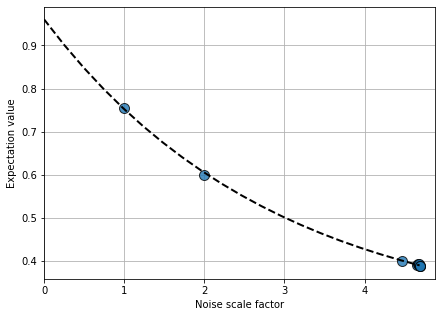

In [24]:
_ = factory.plot_fit()

In [25]:
factory.get_expectation_values()

array([0.75585, 0.59994, 0.40038, 0.39116, 0.39232, 0.39106, 0.38722,
       0.39403, 0.38875, 0.38865])

In [26]:
factory.get_scale_factors()

array([1.        , 2.        , 4.46956499, 4.65002695, 4.66240918,
       4.67994465, 4.68665802, 4.67488215, 4.69063002, 4.68714552])

In [27]:
factory.get_zero_noise_limit()

0.9606057483296139

## Section 3:  Applying probabilistic error cancellation (PEC)

In [28]:
from mitiq import pec

### Build quasi-probability representation for CNOT gate

For simplicity, we assume that:
    
* Only CNOT gates are affected by noise;
* The noise is depolarizing.

Even within these assumptions, we still need to know how strong the noise is. A good approximation is the error probability of the CNOT gate.

In [32]:
# Print error probability of CNOT gate
cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=(0, 1))
cnot_error_prob

# print(qiskit.transpile(circuit, backend=noisy_backend))

0.008339674869236618

We now build a quasi-probability representation based on the previous assumptions. I.e., we represent the ideal CNOT as a linear combination of noisy operations:

$$ \mathcal G_{\rm CNOT} = \sum_\alpha \eta_\alpha \mathcal O_\alpha, \quad \eta_\alpha \in \mathbb R, \quad \{ \mathcal O_\alpha \} = \text{Noisy implementable operations}.$$

In [35]:
from mitiq.pec.representations.depolarizing import represent_operation_with_global_depolarizing_noise

# Define ideal operation that we aim to represent
cnot_circuit = qiskit.QuantumCircuit(qiskit.QuantumRegister(2, name="q")) 
cnot_circuit.cx(0, 1)

# Build representation
cnot_rep = represent_operation_with_global_depolarizing_noise(cnot_circuit, noise_level=cnot_error_prob)

print(f"Quasi-probability representation with one-norm {cnot_rep.norm :g} generated.")
# print(cnot_rep)

Quasi-probability representation with one-norm 1.01683 generated.


### Run PEC

In [36]:
from functools import partial

# Set number of probabilistically generated circuits
num_samples = 100

# Distribute budget of shots among all circuits
shots_per_circuit = shots // num_samples
pec_executor = partial(executor, shots=shots_per_circuit)

# Run PEC
pec_value = pec.execute_with_pec(
    circuit, pec_executor, representations = [cnot_rep], num_samples=num_samples, random_state=0,
)

unmitigated_error = abs(ideal_value - noisy_value)
pec_error = abs(ideal_value - pec_value)
print(f"Estimation error without Mitiq   : {unmitigated_error}")
print(f"Estimation error with Mitiq (PEC): {pec_error}")

Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 214 gate

In [37]:
print(f"PEC reduced the estimation error by {(unmitigated_error - pec_error) / unmitigated_error :.1%}.")

PEC reduced the estimation error by 99.7%.


### Build a noise-agnostic quasi-probability representation for CNOT gate

Instead of a assuming a depolarizing nose model with some given error rate, we now try to use a noise-agnostic representation based on the NEPEC framework introduced in  https://arxiv.org/abs/2108.02237 (Section V). 
More details can be found in the notebook at [this link](https://github.com/unitaryfund/research/blob/main/nepec/noise-agnostic-pec/noise_agnostic_pec.ipynb).

In [38]:
from mitiq.pec import NoisyOperation, OperationRepresentation


def get_richardson_coefficients(scale_factors):
    """Returns the array of Richardson extrapolation coefficients associated
    to the input array of scale factors."""
    
    # This is based on the Lagrange interpolation formula
    richardson_coeffs = []
    for l in scale_factors:
        coeff = 1.0
        for l_prime in scale_factors:
            if l_prime == l:
                continue
            coeff *= l_prime / (l_prime - l)
        richardson_coeffs.append(coeff)

    return richardson_coeffs

def represent_operation_with_nepec(ideal_operation, scale_factors):
    """Returns the OperationRepresentation contructed by noise scaling and extrapolation."""
    
    coeffs = get_richardson_coefficients(scale_factors)
    
    basis_expansion = {}
    for scale_factor, coeff in zip(scale_factors, coeffs):
        scaled_op = NoisyOperation(noise_scaling_function(ideal_operation, scale_factor))
        basis_expansion[scaled_op] = coeff
    
    return OperationRepresentation(ideal_operation, basis_expansion)

In [42]:
scale_factors = [1, 101]  # Large scale factors reduce the PEC sampling cost.
# scale_factors = [1, 3, 9]

agn_rep = represent_operation_with_nepec(cnot_circuit, scale_factors)
print(f"NEPEC quasi-probability representation with one-norm {agn_rep.norm :g} generated.")
# print(agn_rep)

NEPEC quasi-probability representation with one-norm 1.02 generated.


### Run NEPEC (noise-extended PEC)

In [43]:
nepec_value = pec.execute_with_pec(
    circuit, pec_executor, representations = [agn_rep], num_samples=num_samples, random_state=0,
)

unmitigated_error = abs(ideal_value - noisy_value)
nepec_error = abs(ideal_value - nepec_value)
print(f"Estimation error without Mitiq     : {unmitigated_error}")
print(f"Estimation error with Mitiq (NEPEC): {nepec_error}")

Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 411 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 311 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 211 gates using 1000 shots.
Executing circuit with 411 gate

In [45]:
print(f"NEPEC reduced the estimation error by {(unmitigated_error - nepec_error) / unmitigated_error :.1%}.")

NEPEC reduced the estimation error by 95.2%.
